In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

%pylab inline

# Import from the wf-psf package
import wf_psf.GenPolyFieldPSF as wf_gen
import wf_psf.utils as wf_utils
import wf_psf.SimPSFToolkit as wf_sim



Populating the interactive namespace from numpy and matplotlib


In [2]:
# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

# plt.rc('text', usetex=True)
# font = {'family' : 'serif',
#         'weight' : 'bold',
#         'size'   : 20}
font = {'size'   : 14}
mpl.rc('font', **font)


output_path = './figures/'



# Define the dataset parameters

In [22]:
# Parameters defining the dataset
decim_f = 2  # Original shape (1024x1024)

d_max = 2
max_order = 45
x_lims = [0, 1e3]
y_lims = [0, 1e3]
grid_points = [4, 4]
n_bins = 20
verbose = True

max_wfe_rms=0.1
output_dim=64
LP_filter_length=2
euclid_obsc = True
pupil_diameter = 1024//decim_f

n_stars = 200
train_lim = 140

# Saving paths
# output_folder = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/notebooks/psf_field_datasets/'
output_folder = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/github/wf-psf/tf_notebooks/psf_field_dataset/'
save_name = 'dataset_512_bin20_z45_bis'


# Build the generators

In [23]:
Zcube_path = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/data/PA-zernike-cubes/Zernike45.mat'
Zcube = sio.loadmat(Zcube_path)

zernikes = []
# Decimation factor for Zernike polynomials


for it in range(max_order):
    zernike_map = wf_utils.decimate_im(Zcube['Zpols'][0,it][5], decim_f)
    zernikes.append(zernike_map)



In [24]:

# Build param dicitionary
dataset_params = {'d_max':d_max, 'max_order':max_order, 'x_lims':x_lims, 'y_lims':y_lims,
                 'grid_points':grid_points, 'n_bins':n_bins, 'max_wfe_rms':max_wfe_rms,
                 'output_dim':output_dim, 'LP_filter_length':LP_filter_length,
                 'pupil_diameter':pupil_diameter, 'euclid_obsc':euclid_obsc,
                  'n_stars':n_stars, 'train_lim':train_lim}


# Initialize PSF simulator 
sim_PSF_toolkit = wf_sim.SimPSFToolkit(zernikes, max_order=max_order, max_wfe_rms=max_wfe_rms,
                                       output_dim=output_dim, pupil_diameter=pupil_diameter, 
                                       euclid_obsc=euclid_obsc, LP_filter_length=LP_filter_length)

# Initialize PSF field 
gen_poly_fieldPSF = wf_gen.GenPolyFieldPSF(sim_PSF_toolkit, d_max=d_max,
                                           grid_points=grid_points, max_order=max_order,
                                           x_lims=x_lims, y_lims=y_lims, n_bins=n_bins,
                                           lim_max_wfe_rms=max_wfe_rms, verbose=verbose)


In [25]:
# gen_poly_fieldPSF.C_poly = C_poly

# C_poly.shape

## Handle SEDs

In [26]:
# Load the SEDs

SED_path = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/notebooks/explore_SEDs/save_SEDs/'

stellar_SEDs = np.load(SED_path + 'SEDs.npy', allow_pickle=True)
stellar_lambdas = np.load(SED_path + 'lambdas.npy', allow_pickle=True)


In [27]:

SED_list = []

# Select SEDs
for it in range(n_stars):
    selected_id_SED = np.random.randint(low=0, high=13)
    concat_SED_wv = np.concatenate((stellar_lambdas.reshape(-1,1),
                                    stellar_SEDs[selected_id_SED,:].reshape(-1,1)), axis=1)
    SED_list.append(concat_SED_wv)
    


# Select random positions

In [28]:
# First we choose the locations (randomly)
pos_np = np.random.rand(n_stars,2)

pos_np[:,0] = pos_np[:,0]*(x_lims[1] - x_lims[0]) + x_lims[0]
pos_np[:,1] = pos_np[:,1]*(y_lims[1] - y_lims[0]) + y_lims[0]


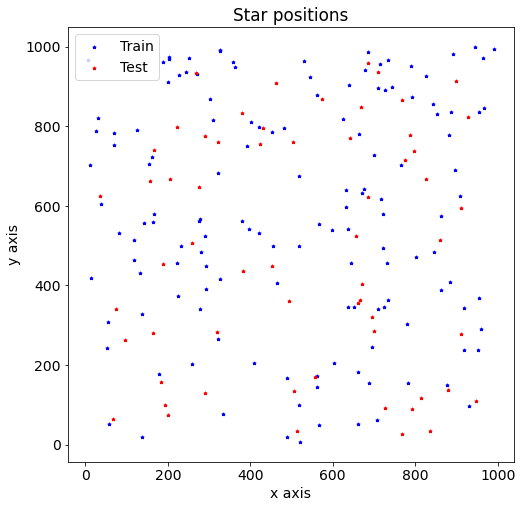

In [29]:
# Check out the positions

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
im1 = ax1.scatter(pos_np[:train_lim,0], pos_np[:train_lim,1], s=10., c='blue', marker='*', label='Train')
im1 = ax1.scatter(pos_np[train_lim:,0], pos_np[train_lim:,1], s=10., c='red', marker='*', label='Test')
ax1.set_title('Star positions')
ax1.set_xlabel('x axis')
ax1.set_ylabel('y axis')
ax1.legend()
plt.show()


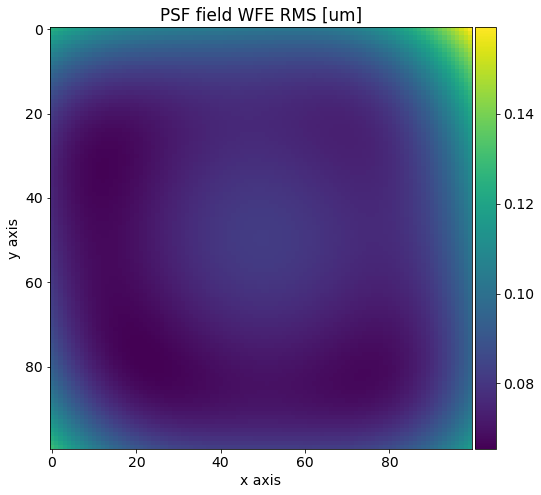

In [30]:
# Plot how the future PSF field WFE_RMS looks like
gen_poly_fieldPSF.show_WFE_RMS()


# Generate dataset

In [31]:
# Generate the PSFs
poly_psf_list = []
opd_list = []
zernike_coef_list = []

for it in tqdm(range(n_stars)):
    _psf, _zernike, _opd = gen_poly_fieldPSF.get_poly_PSF(xv_flat=pos_np[it, 0],
                                                          yv_flat=pos_np[it, 1],
                                                          SED=SED_list[it])
    
    poly_psf_list.append(_psf)
    opd_list.append(_opd)
    zernike_coef_list.append(_zernike)


100%|██████████| 200/200 [10:20<00:00,  3.10s/it]


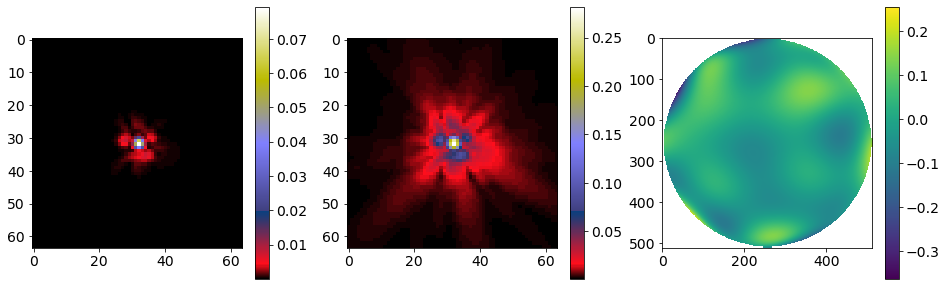

WFE RMS: 0.063149


In [32]:
# Let's inspect one sample from the dataset
_it = 2

figure(figsize=[16,5])
subplot(131)
imshow(poly_psf_list[_it], cmap='gist_stern');colorbar()

subplot(132)
imshow(np.sqrt(poly_psf_list[_it]), cmap='gist_stern');colorbar()

subplot(133)
imshow(opd_list[_it]);colorbar()
# plt.savefig('./example_PSF_n%d.pdf'%(_it), bbox_inches='tight')

show()

print('WFE RMS: %f'%(np.sqrt(np.sum(zernike_coef_list[_it]**2))))


# Save the dataset

In [33]:
# Generate numpy arrays from the lists
poly_psf_np = np.array(poly_psf_list)
opd_np = np.array(opd_list)
zernike_coef_np = np.array(zernike_coef_list)
SED_np = np.array(SED_list)


In [34]:
print(poly_psf_np.shape)
print(opd_np.shape)
print(zernike_coef_np.shape)
print(SED_np.shape)
print(pos_np.shape)

(200, 64, 64)
(200, 512, 512)
(200, 45, 1)
(200, 352, 2)
(200, 2)


In [35]:
# Generate dictionary and save

C_poly = gen_poly_fieldPSF.C_poly

train_psf_dataset = {'stars' : poly_psf_np[:train_lim, :, :],
                     'positions' : pos_np[:train_lim, :],
                     'SEDs' : SED_np[:train_lim, :, :],
                     'zernike_coef' : zernike_coef_np[:train_lim, :, :],
                     'C_poly' : C_poly,
                     'parameters': dataset_params}

test_psf_dataset = {'stars' : poly_psf_np[train_lim:, :, :],
                     'positions' : pos_np[train_lim:, :],
                     'SEDs' : SED_np[train_lim:, :, :],
                     'zernike_coef' : zernike_coef_np[train_lim:, :, :],
                     'C_poly' : C_poly,
                     'parameters': dataset_params}


In [36]:

np.save(output_folder + 'train_' + save_name + '.npy', train_psf_dataset, allow_pickle=True)
np.save(output_folder + 'test_' + save_name + '.npy', test_psf_dataset, allow_pickle=True)
